Dataset Shape: (9168, 21)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9168 non-null   int64  
 1   brand                   9168 non-null   object 
 2   category                9168 non-null   object 
 3   name                    9168 non-null   object 
 4   size                    9168 non-null   object 
 5   rating                  9168 non-null   float64
 6   number_of_reviews       9168 non-null   int64  
 7   love                    9168 non-null   int64  
 8   price                   9168 non-null   float64
 9   value_price             9168 non-null   float64
 10  URL                     9168 non-null   object 
 11  MarketingFlags          9168 non-null   bool   
 12  MarketingFlags_content  9168 non-null   object 
 13  options                 9168 non-null   object 
 14  

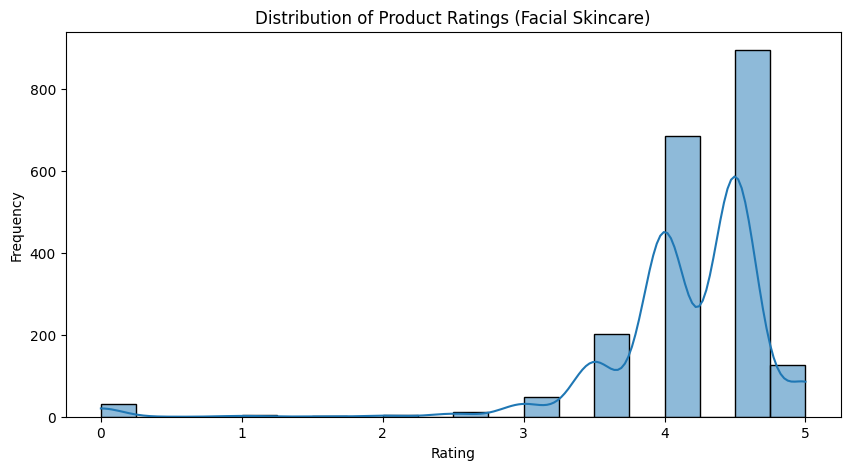

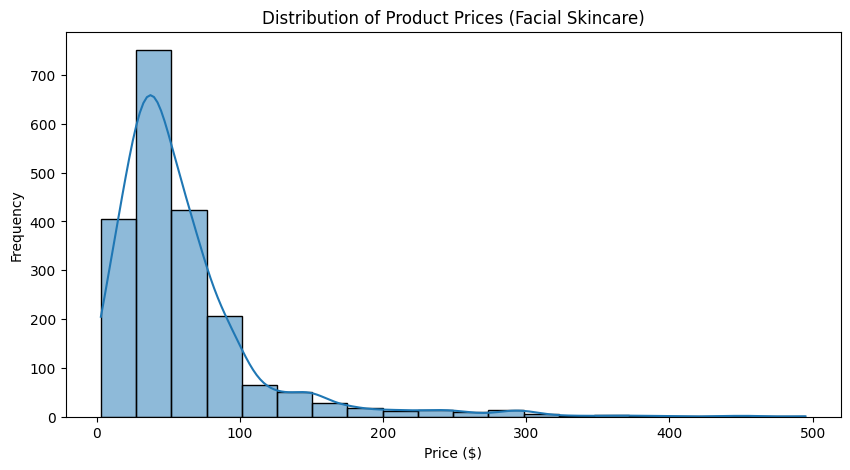

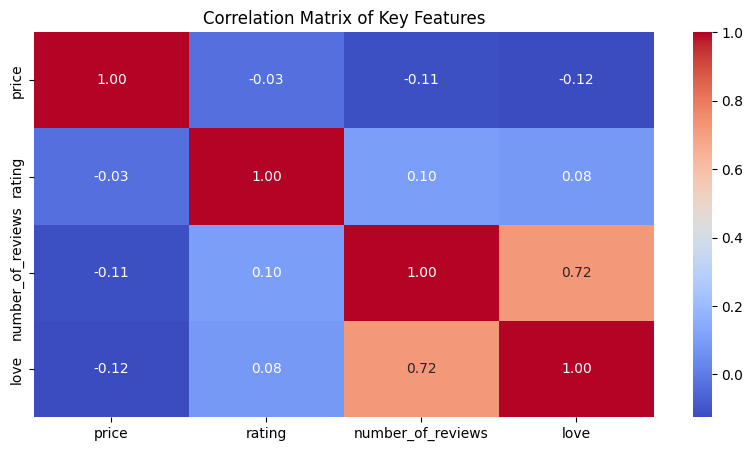

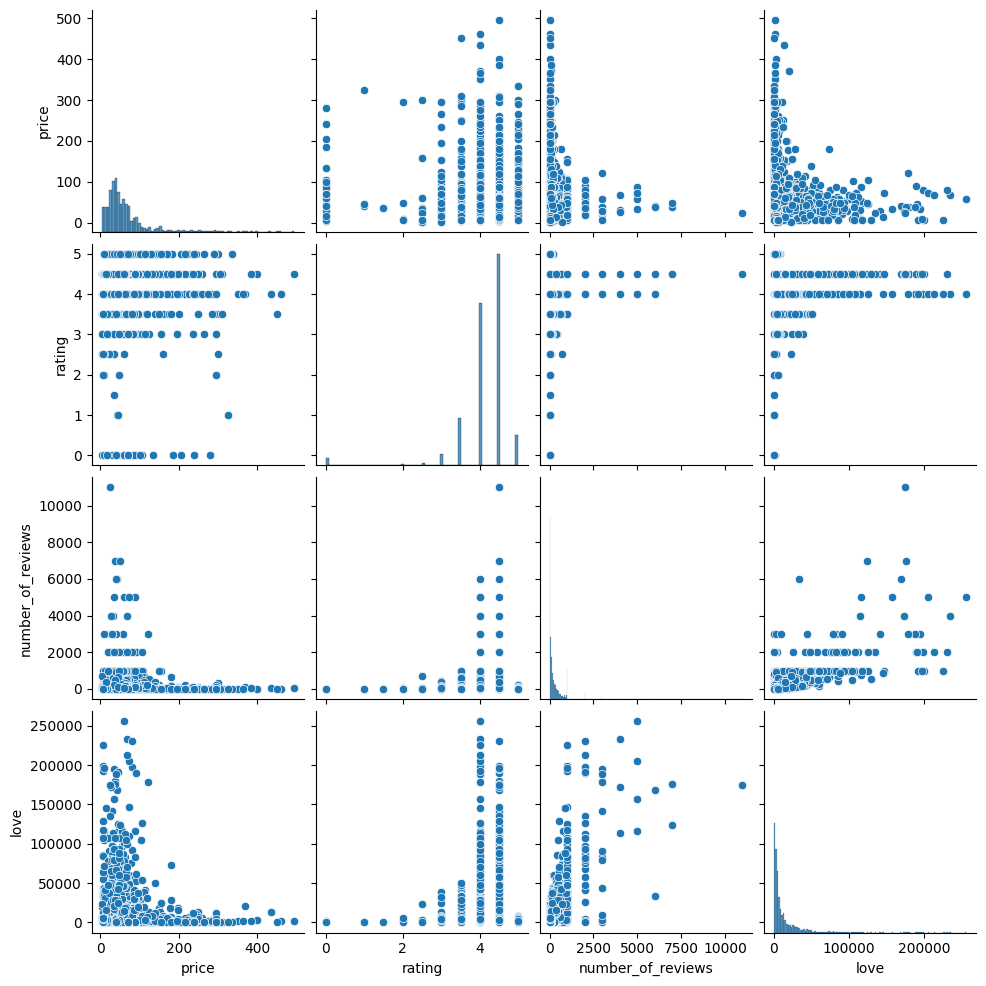

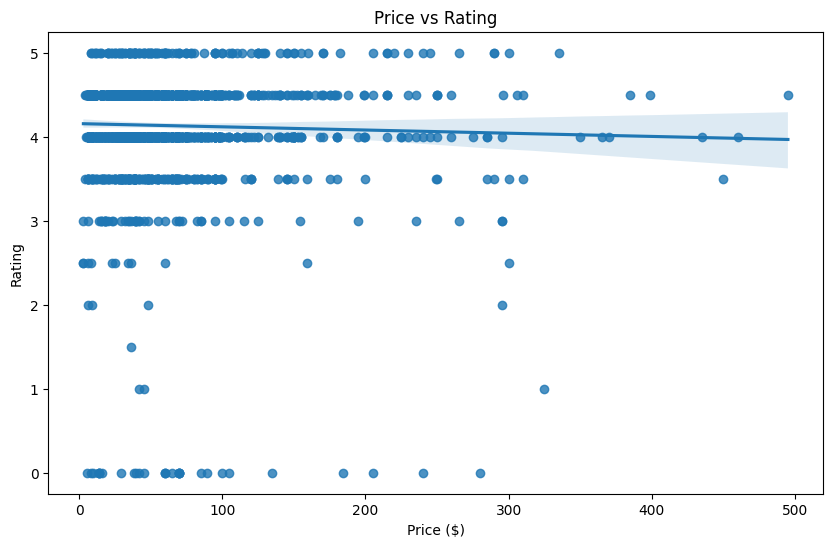

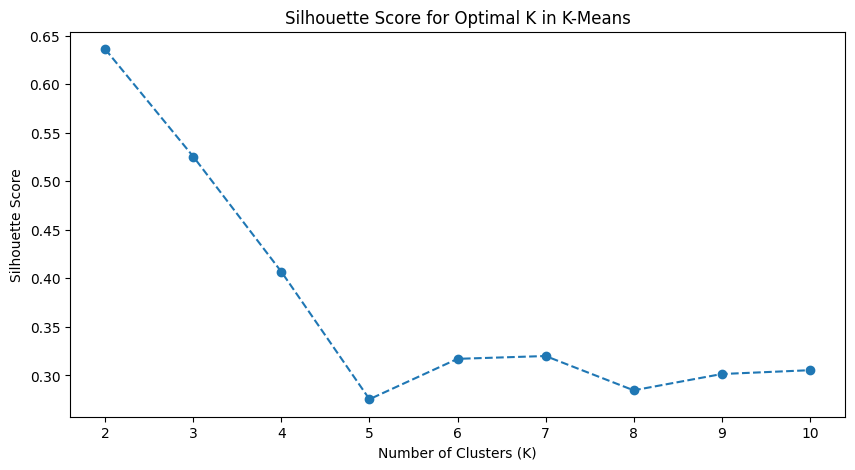

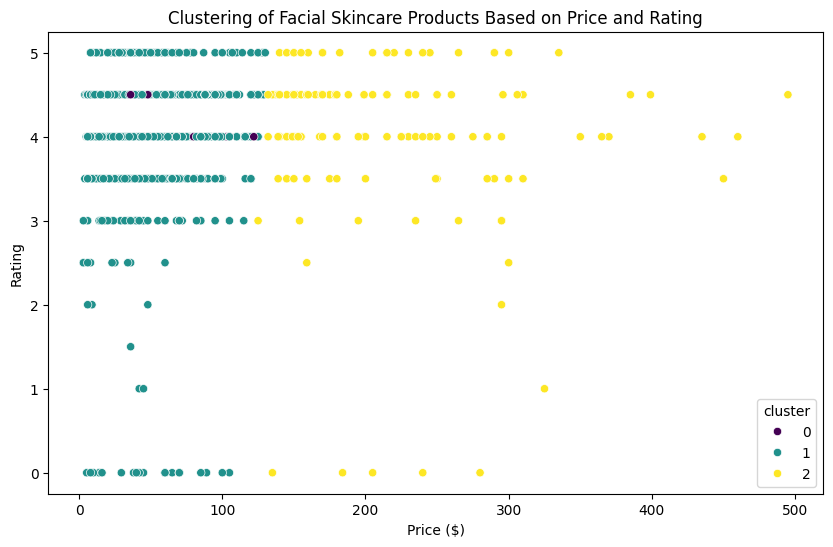

Mean Squared Error: 0.22303967039800998
R-squared Score: 0.6223148094630595


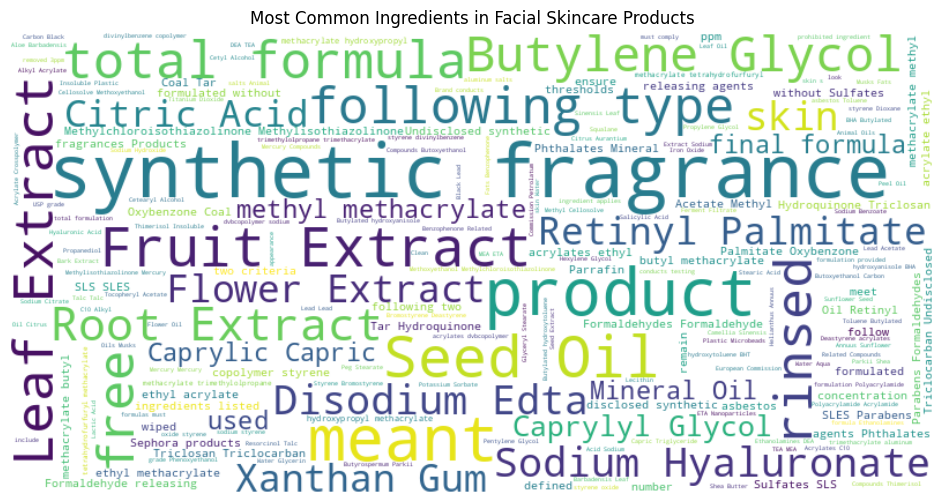

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestRegressor

# Step 1: Data Acquisition and Preliminary Exploration
# Load the dataset
file_path = "/content/sephora_website_dataset.csv"
df = pd.read_csv(file_path)

# Dataset Overview
print("Dataset Shape:", df.shape)
print("Dataset Info:")
print(df.info())
print("Dataset Head:")
print(df.head())

# Data Cleaning and Preprocessing
df.replace("unknown", pd.NA, inplace=True)
binary_cols = ["online_only", "exclusive", "limited_edition", "limited_time_offer"]
df[binary_cols] = df[binary_cols].astype(bool)
df_cleaned = df.drop(columns=["id", "URL", "MarketingFlags_content", "options", "details", "how_to_use"])

# Filtering dataset for Facial Skincare categories
skincare_categories = [
    "Face Serums", "Moisturizers", "Eye Creams & Treatments", "Face Sunscreen",
    "Face Masks", "Face Wash & Cleansers", "Face Oils", "Facial Peels",
    "Exfoliators", "Toners", "Sheet Masks", "Anti-Aging", "Night Creams",
    "Blemish & Acne Treatments"
]
df_facial_skincare = df_cleaned[df_cleaned["category"].isin(skincare_categories)]

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 5))
sns.histplot(df_facial_skincare['rating'], bins=20, kde=True)
plt.title("Distribution of Product Ratings (Facial Skincare)")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_facial_skincare['price'], bins=20, kde=True)
plt.title("Distribution of Product Prices (Facial Skincare)")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

# Expanded Correlation Analysis
plt.figure(figsize=(10, 5))
corr_matrix = df_facial_skincare[['price', 'rating', 'number_of_reviews', 'love']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Key Features")
plt.show()

# Pairplot to Show Relationships
sns.pairplot(df_facial_skincare[['price', 'rating', 'number_of_reviews', 'love']])
plt.show()

# Scatterplot with Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x=df_facial_skincare['price'], y=df_facial_skincare['rating'])
plt.title("Price vs Rating")
plt.xlabel("Price ($)")
plt.ylabel("Rating")
plt.show()

# Step 2: Model Development
# Clustering Analysis (K-Means with Silhouette Score)
from sklearn.metrics import silhouette_score
clustering_data = df_facial_skincare[['price', 'rating', 'number_of_reviews', 'love']].dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title("Silhouette Score for Optimal K in K-Means")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

# Applying K-Means Clustering with optimal K=3
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_data['cluster'] = kmeans.fit_predict(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=clustering_data['price'], y=clustering_data['rating'], hue=clustering_data['cluster'], palette='viridis')
plt.title("Clustering of Facial Skincare Products Based on Price and Rating")
plt.xlabel("Price ($)")
plt.ylabel("Rating")
plt.show()

# Regression Model: Predicting Product Ratings Based on Features
X = df_facial_skincare[['price', 'number_of_reviews', 'love']].dropna()
y = df_facial_skincare.loc[X.index, 'rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor for Predictive Modeling
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))

# Step 3: Ingredient Analysis
if "ingredients" in df_facial_skincare.columns:
    ingredients_text = " ".join(df_facial_skincare["ingredients"].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ingredients_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Most Common Ingredients in Facial Skincare Products")
    plt.show()

    # Ingredient Effectiveness Analysis
    ingredient_counts = Counter(ingredients_text.split(", "))
    ingredient_df = pd.DataFrame(ingredient_counts.items(), columns=["Ingredient", "Count"]).sort_values(by="Count", ascending=False).head(20)

    # Plotting the bar plot with fixed hue issue and suppressing warning
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Count", y="Ingredient", data=ingredient_df, dodge=False)

    # Manually add a legend by creating custom labels for the ingredients
    plt.title("Most Frequently Used Ingredients in Facial Skincare Products")
    plt.xlabel("Frequency")
    plt.ylabel("Ingredient")

    # Create custom labels for the legend (using the top ingredients list)
    labels = ingredient_df["Ingredient"].tolist()
    plt.legend(labels=labels, title="Ingredient", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

    plt.show()

# GitHub Link: [Provide your GitHub link here with the full analysis]
